# Credible set size quality controls

The goal of the analusis is to check the distribution of the credible set sizes

- across the major ancestry groups
- across study types


## Data Loading

The data required for this analysis is loaded from the `computed maf` dataset.


In [1]:
from gentropy.common.session import Session

from manuscript_methods import aggregated_statistics, plot_aggregated_data, plot_distribution
from manuscript_methods.datasets import LeadVariantEffect


Loading BokehJS ...

In [2]:
session = Session(extended_spark_conf={"spark.driver.memory": "40G"})
lead_maf_dataset_path = "../../data/lead-maf-vep"


25/06/23 08:14:38 WARN Utils: Your hostname, mindos resolves to a loopback address: 127.0.1.1; using 192.168.0.100 instead (on interface eno1)
25/06/23 08:14:38 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/23 08:14:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/23 08:14:39 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
session.spark


In [4]:
dataset_maf = LeadVariantEffect.from_parquet(session, lead_maf_dataset_path)
dataset = dataset_maf.df.select(
    "studyLocusId",
    "variantId",
    "credibleSetSize",
    "studyStatistics.studyType",
)


In [5]:
dataset.describe().show()


25/06/23 08:14:42 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+--------------------+----------------+------------------+---------+
|summary|        studyLocusId|       variantId|   credibleSetSize|studyType|
+-------+--------------------+----------------+------------------+---------+
|  count|             2833758|         2833758|           2833758|  2833758|
|   mean|            Infinity|            NULL|24.635404293521184|     NULL|
| stddev|                 NaN|            NULL| 87.11131863249854|     NULL|
|    min|0000075e718162e97...|10_100000235_C_T|                 1| cis-pqtl|
|    max|fffffef27b8b270d5...|  Y_20577481_C_T|             10248|    tuqtl|
+-------+--------------------+----------------+------------------+---------+



## Plot the distribution of credible set sizes

The credible set size is computed based on the number of unique variants in the **studyLocus.locus object**.

<img src="plots/01.3_credible_set_size_overall.jpg" width="600">


/home/mindos/Projects/OpenTargets/Gentropy-manuscript/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5.35 x 4.5 in image.
/home/mindos/Projects/OpenTargets/Gentropy-manuscript/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: plots/01.3_credible_set_size_overall.jpg


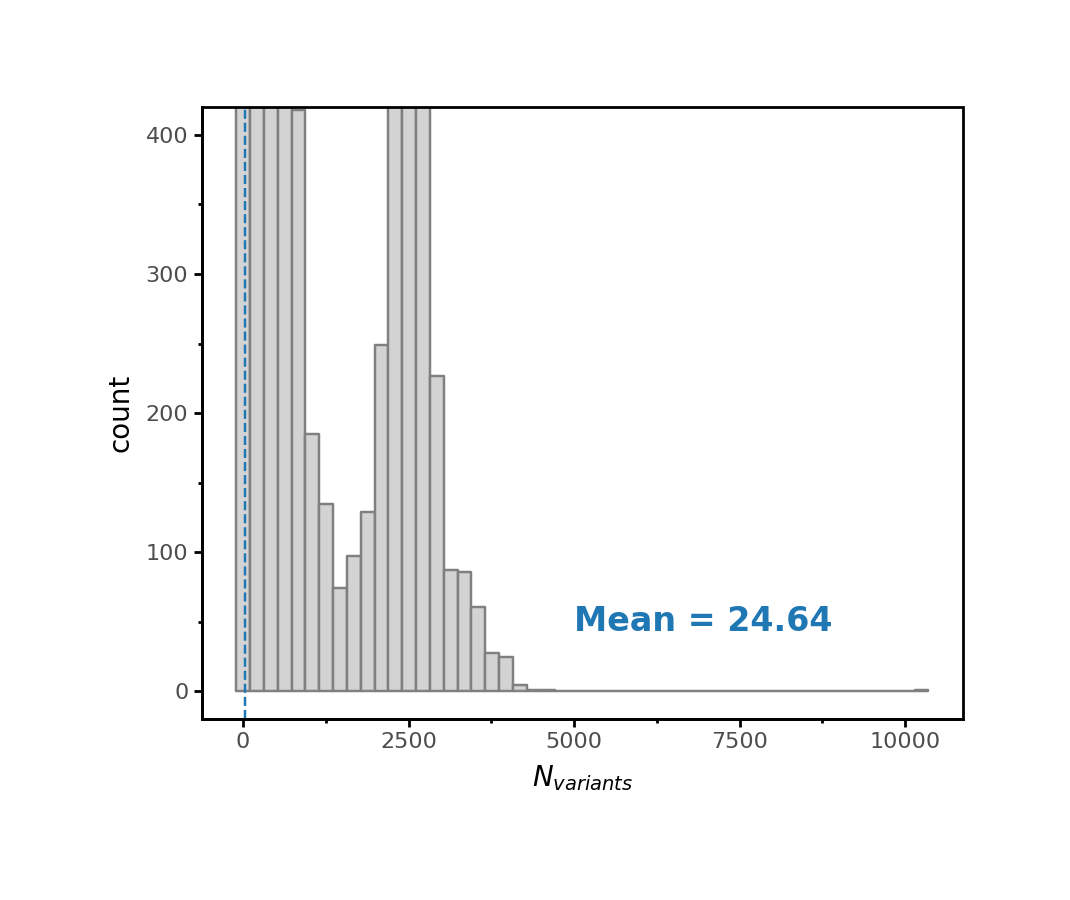

In [6]:
p = plot_distribution(dataset, factor="credibleSetSize", xtitle=r"$N_{variants}$")
p.save("plots/01.3_credible_set_size_overall.jpg", dpi=300, bbox_inches="tight")
p


## Distribution of credible set study types

The study types were derived from the `studyIndex.studyType` column and enhanced by the `studyLocus.isTransQtl` column.

<img src="plots/01.3_credible_set_size_by_study_type.jpg" width="600">



In [7]:
aggr_stats = aggregated_statistics(dataset, group_columns=["studyType"], agg_column="credibleSetSize").show()


+----------+-------+------------------+------------------+-----+---+
| studyType|  count|              mean|            stddev|  max|min|
+----------+-------+------------------+------------------+-----+---+
|      eqtl|1349478|24.735926039550108| 74.83189536874572| 4136|  1|
|      gwas| 789453|24.610909072484365|105.26355676548242|10248|  1|
|     tuqtl| 384852| 22.17207913691497| 58.33121790494405| 4042|  1|
|      sqtl| 223500|21.606331096196868| 48.22481439440277| 3715|  1|
|    sceqtl|  52744|60.795066737448806|245.06590424008525| 4612|  1|
|trans-pqtl|  17678|17.961081570313382| 80.82612119275365| 2848|  1|
|  cis-pqtl|  16053| 7.160966797483336| 22.28840766484777| 1059|  1|
+----------+-------+------------------+------------------+-----+---+



/home/mindos/Projects/OpenTargets/Gentropy-manuscript/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5.35 x 4.5 in image.
/home/mindos/Projects/OpenTargets/Gentropy-manuscript/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: plots/01.3_credible_set_size_by_study_type.jpg


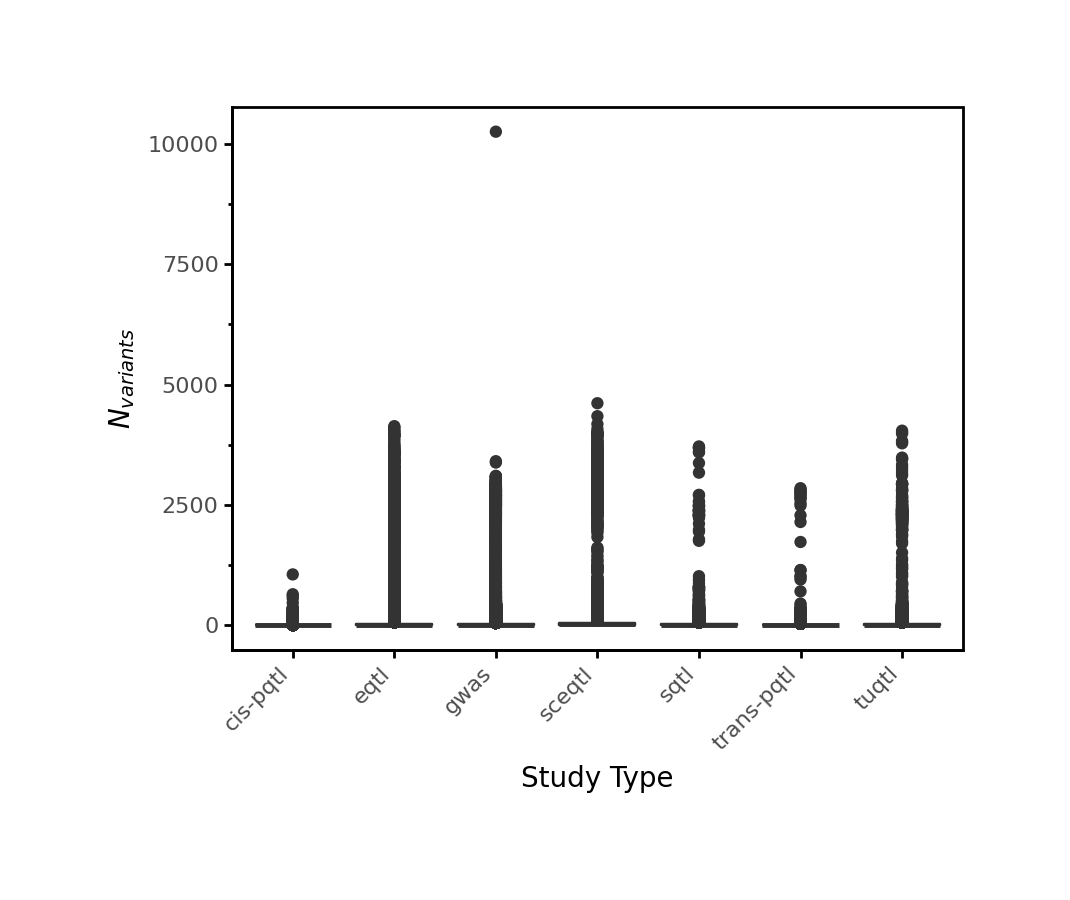

In [8]:
data = dataset.select("studyType", "credibleSetSize")

plot = plot_aggregated_data(data, x="studyType", y="credibleSetSize", xtitle="Study Type", ytitle=r"$N_{variants}$")
plot.save("plots/01.3_credible_set_size_by_study_type.jpg", dpi=300, bbox_inches="tight")
plot


## See the outliers
Compute the 99% quantile for the credible set size and filter the dataset

In [15]:
Q99 = (
    data.toPandas()
    .groupby("studyType")["credibleSetSize"]
    .quantile(0.99)
    .reset_index()
    .rename(columns={"credibleSetSize": "credibleSetSizeQ95"})
)
Q99


,studyType,credibleSetSizeQ95
0,cis-pqtl,90.00
1,eqtl,182.00
2,gwas,229.00
3,sceqtl,449.57
4,sqtl,159.00
5,trans-pqtl,159.23
6,tuqtl,160.00


### Check the cutoff > 5k

In [23]:
from pyspark.sql import functions as f

dataset_maf.df.filter(f.col("credibleSetSize") > 5000).select(
    "studyId", "studyStatistics.studyType", "credibleSetSize"
).show(truncate=False)


+-----------------------+---------+---------------+
|studyId                |studyType|credibleSetSize|
+-----------------------+---------+---------------+
|FINNGEN_R12_I9_CVD_HARD|gwas     |10248          |
+-----------------------+---------+---------------+

